<a href="https://colab.research.google.com/github/awiteck/DeepLearningAssignments/blob/main/data_formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1: Load in data and make it more robust.

Code adapted from https://www.kaggle.com/code/balraj98/yolo-v5-car-object-detection

In [86]:
data_path = "/content/drive/MyDrive/DeepLearningProject/data"

In [87]:
df = pd.read_csv(f'{data_path}/train_solution_bounding_boxes.csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,304.493488,205.130309,46.468886,36.190476,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,67.746744,211.732625,105.166425,49.395109,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,300.580318,206.597490,122.775687,59.665380,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,563.251809,201.951416,133.536903,59.176319,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,74.594790,212.466216,115.927641,51.840412,0


In [89]:
df

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,304.493488,205.130309,46.468886,36.190476,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,67.746744,211.732625,105.166425,49.395109,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,300.580318,206.597490,122.775687,59.665380,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,563.251809,201.951416,133.536903,59.176319,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,74.594790,212.466216,115.927641,51.840412,0
...,...,...,...,...,...,...,...,...,...,...
554,vid_4_9860,0.000000,198.321729,49.235251,236.223284,24.617626,217.272506,49.235251,37.901554,0
555,vid_4_9880,329.876184,156.482351,536.664239,250.497895,433.270211,203.490123,206.788055,94.015544,0
556,vid_4_9900,0.000000,168.295823,141.797524,239.176652,70.898762,203.736237,141.797524,70.880829,0
557,vid_4_9960,487.428988,172.233646,616.917699,228.839864,552.173343,200.536755,129.488711,56.606218,0


Step 2: Normalize values (model will predict `x_center` and `y_center`, as well as `w` and `h`, so we only have to normalize those)

In [49]:
img_h, img_w, num_channels = (380, 676, 3)
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


**Preliminary visualization**

In [50]:
img_ids = ["vid_4_1000", "vid_4_10000", "vid_4_30440"]

In [51]:
imgs = [cv2.imread(f"{data_path}/training_images/{img_ids[i]}.jpg").resize() for i in range(len(img_ids))]
bboxs = [df[df['image_id'] == img_ids[i]] for i in range(len(img_ids))]

In [52]:
def visualize_bbox(img, bbox):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox.iloc[0]['xmin'], 
                              bbox.iloc[0]['ymin']), 
                             bbox.iloc[0]['xmax'] - bbox.iloc[0]['xmin'], 
                             bbox.iloc[0]['ymax'] - bbox.iloc[0]['ymin'], 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

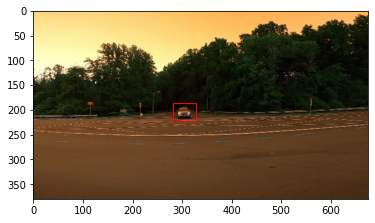

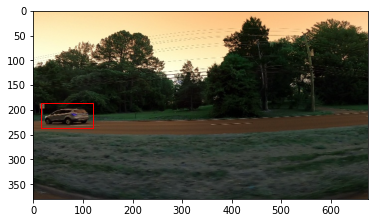

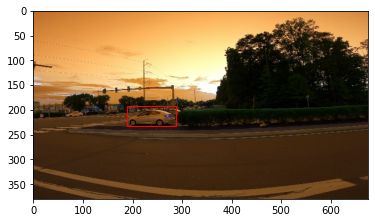

In [53]:
for i in range(len(img_ids)):
    visualize_bbox(imgs[i], bboxs[i])

Convert to matrix form

In [106]:
filelist_df = df['image_id'].to_numpy()
filelist_df[:5]


array(['vid_4_1000', 'vid_4_10000', 'vid_4_10040', 'vid_4_10020',
       'vid_4_10060'], dtype=object)

In [107]:
filelist_big = glob.glob(f'{data_path}/training_images/*')

In [108]:
filelist = []

In [109]:
for file in filelist_df:
  if f'{data_path}/training_images/{file}.jpg' in filelist_big:
    filelist.append(file)

In [112]:
x_train = np.array([np.array(Image.open(f'{data_path}/training_images/{fname}.jpg')) for fname in filelist])

In [114]:
y_train = df[["image_id", "x_center", "y_center", "w", "h"]].to_numpy()

In [117]:
x_train.shape, y_train.shape

((559, 380, 676, 3), (559, 5))